In [1]:
# 1.) What was the change in price of the stock over time?
# 2.) What was the daily return of the stock on average?
# 3.) What was the moving average of the various stocks?
# 4.) What was the correlation between different stocks'?
# 5.) How much value do we put at risk by investing in a particular stock?
# 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Scale the data
from sklearn.preprocessing import MinMaxScaler

# Keras with the model
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #, root_mean_squared_error

# For time stamps
from datetime import datetime

# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name


[*********************100%%**********************]  1 of 1 completed


In [3]:
# Get the stock quote
df = AAPL.copy() 

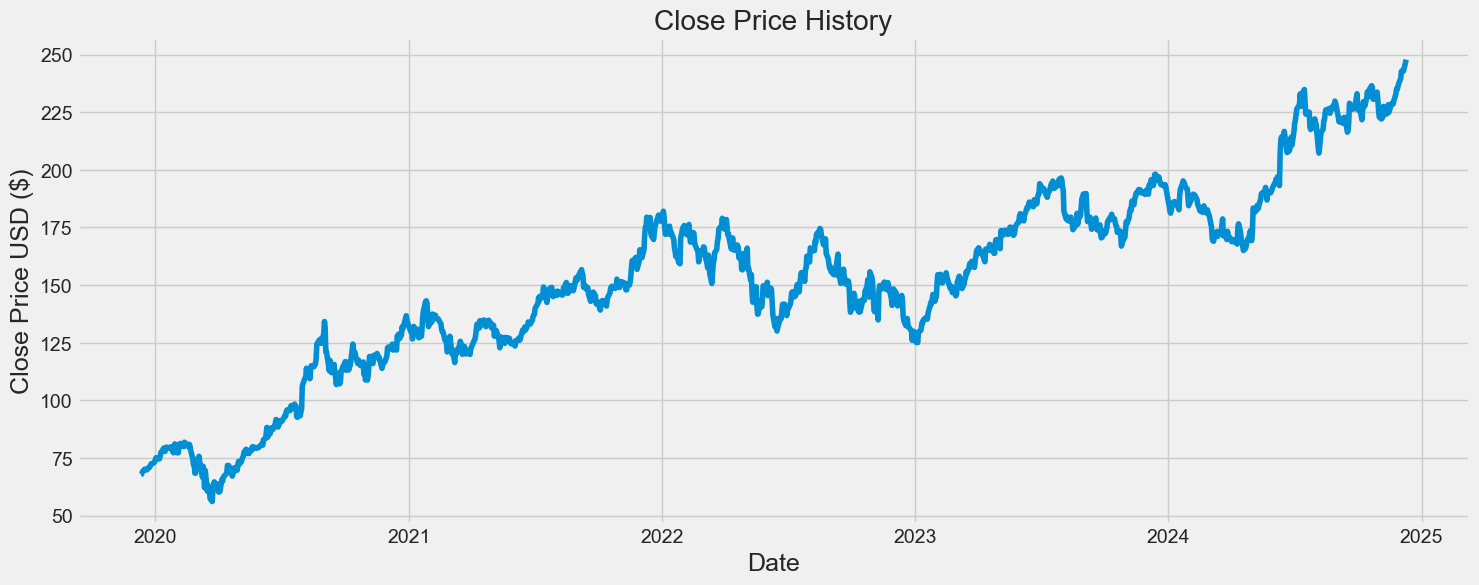

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close colum
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape

[array([0.06051831, 0.06141826, 0.06623104, 0.07237416, 0.07309153,
       0.07221765, 0.07258284, 0.07182638, 0.07777387, 0.07812601,
       0.08548213, 0.08533864, 0.087582  , 0.09036011, 0.09909876,
       0.09529026, 0.09838138, 0.09654239, 0.10280289, 0.11120242,
       0.11211539, 0.12076273, 0.11518044, 0.11343272, 0.11851938,
       0.12307132, 0.12025409, 0.12172792, 0.12372346, 0.12252351,
       0.11031552, 0.12171487, 0.13038828, 0.12977527, 0.11104591,
       0.10993727, 0.12322783, 0.12661895, 0.13152299, 0.12476686,
       0.12674934, 0.12421905, 0.13411852, 0.13107954, 0.13118391,
       0.12342346, 0.1294492 , 0.125119  , 0.11566301, 0.09626847,
       0.08309529, 0.08905583, 0.06410506, 0.06389637, 0.09709016,
       0.08471262, 0.10221595, 0.08940801, 0.08433437, 0.05451868])]
[0.07952159157100147]

[array([0.06051831, 0.06141826, 0.06623104, 0.07237416, 0.07309153,
       0.07221765, 0.07258284, 0.07182638, 0.07777387, 0.07812601,
       0.08548213, 0.08533864, 0.08

In [8]:
firstLayer = range(32, 512, 32)
secondLayer = range(32, 128, 32)
firstDensity = range(10, 50, 10)
secondDensity = range(1, 6, 2)
epochs = range(1, 3, 1)

counter = 0

colums = ['Units firstLayer', 'Units SecondLayer','firstDensity', 'secondDensity', 'Epochs' , 'MSE', 'RMSE', 'MAE', 'R2']
results = pd.DataFrame(columns=colums)

for fl in firstLayer:
    for sl in secondLayer:
        for fd in firstDensity:
            # for sd in secondDensity:
            for ep in epochs:
                # Build the LSTM model
                model = Sequential()
                model.add(LSTM(units=fl, return_sequences=True, input_shape=(x_train.shape[1], 1)))
                model.add(LSTM(units=sl, return_sequences=False))
                model.add(Dense(fd))
                model.add(Dense(1))

                # Compile the model
                model.compile(optimizer='adam', loss='mean_squared_error')

                # Train the model
                model.fit(x_train, y_train, batch_size=1, epochs=ep)

                # Create the testing data set
                # Create a new array containing scaled values from index 1543 to 2002 
                test_data = scaled_data[training_data_len - 60: , :]

                # Create the data sets x_test and y_test
                x_test = []
                y_test = dataset[training_data_len:, :]

                for i in range(60, len(test_data)):
                    x_test.append(test_data[i-60:i, 0])

                # Convert the data to a numpy array
                x_test = np.array(x_test)

                # Reshape the data
                x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

                # Get the models predicted price values 
                predictions = model.predict(x_test)
                predictions = scaler.inverse_transform(predictions)

                # Assuming y_test are the actual values and y_pred are the predicted values
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
                #rmse = root_mean_squared_error(y_test, predictions)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                results.loc[counter] = [fl,  sl,  fd,  1,  ep,  mse,  rmse,  mae,  r2]
                counter +=1


2/2 [==============================] - 1s 11ms/step
Epoch 1/2
1136/1136 [==============================] - 29s 23ms/step - loss: 0.0023
Epoch 2/2
2/2 [==============================] - 1s 10ms/step
Epoch 1/2
1136/1136 [==============================] - 29s 23ms/step - loss: 0.0029
Epoch 2/2
2/2 [==============================] - 1s 10ms/step
Epoch 1/2
1136/1136 [==============================] - 29s 23ms/step - loss: 0.0027
Epoch 2/2
2/2 [==============================] - 1s 10ms/step
Epoch 1/2
1136/1136 [==============================] - 29s 23ms/step - loss: 0.0028
Epoch 2/2
2/2 [==============================] - 1s 17ms/step
Epoch 1/2
1136/1136 [==============================] - 27s 21ms/step - loss: 0.0025
Epoch 2/2
2/2 [==============================] - 1s 16ms/step
Epoch 1/2
1136/1136 [==============================] - 27s 21ms/step - loss: 0.0023
Epoch 2/2
2/2 [==============================] - 1s 16ms/step
Epoch 1/2
1136/1136 [==============================] - 28s 22ms/step - l

KeyboardInterrupt: 

In [ ]:
display(results)
import os
import pickle

results.sort_values(by=['MSE','RMSE'] ).to_csv('results 5 years.csv', decimal=',')

,Units firstLayer,Units SecondLayer,firstDensity,secondDensity,Epochs,MSE,RMSE,MAE,R2
0,32.0,32.0,10.0,1.0,1.0,44.732784,6.688257,5.399625,0.664376
1,32.0,32.0,10.0,1.0,2.0,76.077858,8.722262,7.215748,0.429198
2,32.0,32.0,20.0,1.0,1.0,168.248319,12.971057,11.476203,-0.262344
3,32.0,32.0,20.0,1.0,2.0,50.855728,7.131320,5.849528,0.618437
4,32.0,32.0,30.0,1.0,1.0,103.114113,10.154512,8.493080,0.226349
...,...,...,...,...,...,...,...,...,...
355,480.0,96.0,20.0,1.0,2.0,59.693666,7.726168,6.878209,0.552127
356,480.0,96.0,30.0,1.0,1.0,25.625818,5.062195,4.057013,0.807733
357,480.0,96.0,30.0,1.0,2.0,20.817450,4.562614,3.374431,0.843810
358,480.0,96.0,40.0,1.0,1.0,37.055673,6.087337,4.915999,0.721976
